In [17]:
'''Calculates SVD of cleaned EEG
requires cleaned files (segment_edit)'''
from hdf5storage import loadmat, savemat
import numpy as np
from matplotlib import pyplot as plt
from hnlpy.timeop import baselinecorrect
from hnlpy.timeop import makefiltersos
import scipy.signal as signal



In [18]:
def avref(datax,bchan=[]):
	""" Assumes datax is time by channels"""
	nchan = np.shape(datax)[1]
	gchan = np.setdiff1d(range(nchan),bchan)
	ref = np.mean(datax[:,gchan],axis = 1)
	refmat = np.tile(ref,(np.shape(datax)[1],1))
	datax = datax - np.transpose(refmat)
	if len(bchan) != 0:
		datax[:,bchan] = 0
	return datax

In [27]:
sub = '105'
ses = '3'
take_ends = False
path = f'split_cleaned/{sub}SS{ses}_split_cleaned.hdf.mat'
data = loadmat(path)


In [28]:
data.keys()

dict_keys(['answer', 'block', 'channel_labels', 'channel_location', 'choice', 'eeg', 'failed_channels', 'feature_end', 'feature_start', 'filter', 'icastat', 'index order', 'model_response', 'ordered_features', 'pk_choice', 'pk_off', 'pk_responsetime', 'pk_start', 'responsetime', 'samplingrate', 'time', 'use_channels'])

In [30]:
#unpack the dictionary for behavioral analysis 
answer = data['answer']
#cedrus = data['cedrus_response']
choice = data['choice'].astype(int)
good_trials = data['icastat']['good_trials']
of = data['ordered_features']
responsetime = data['responsetime']
#unpack the dictionary for erp analysis 
eeg = data['eeg']
failed_channels = data['failed_channels']
#this is a temporary fix, hopefully it can be corrected tomorrow
#THIS SHOULD BE REMOVED ONCE THE FILE IS FIXED
#for j in range(np.shape(eeg_1)[0]):
#	trial = eeg_1[j,:,:]
#	trial = avref(trial,failed_channels)
#	eeg_1[j,:,:] = trial 
#eeg = np.zeros((1950,np.shape(eeg_1)[1],np.shape(eeg_1)[2]))
#eeg[eegtrials,:,:] = eeg_1
#THIS SHOULD BE REMOVED ONCE FILE IS FIXED 

channel_labels = data['channel_labels']
channel_localtion = data['channel_location']
#good_trials = data['good_trials']
# position = data['position']
sr = data['samplingrate']
time = data['time']
use_channels = data['use_channels']
# trial = data['trial']




for i in range(int(eeg.shape[0]/5)):
    plt.plot(eeg[i*5:i*5+5].reshape(5000,128))
    plt.show()


Next block of code does some handling of the stimulus sequences and their labels.  This needs to be validated by Shane against his original cvs files. 

Here i make separate list of the stimulus type and the stimulus value for each stimulus.  Every 10th one should be the response cue.  

In [90]:
stimtype = list()
stimval = list()
for j in range(len(of)):
	x = of[j].split(':')
	if len(x) == 2:
		stimtype.append(x[0])
		if x[0] == 'Age':
			x[1] = int(x[1])
		elif x[0] == 'Hours per Week':
			x[1] = int(x[1])
		else:
			x[1] = x[1][1:]
		stimval.append(x[1])
	else:
		stimtype.append(x[0])
		stimval.append(x[0])


Here i extract the unique value of the stimtype as the feature_list.  then, I also extract all the unique feature values.  For my convenience, what I do next is to make a numerical version of stimtype, which i can stim_index.  
Then I make a couple of arrays to identify which features are categorical (versus numerical).  I also make one to keep track of the fact that the response cue is not a feature, but is an eeg stimulus.  

In [91]:

feature_list = list(np.unique(stimtype))
feature_values = dict()
for j in feature_list:
	feature_values[j] = list()
for j in range(len(stimval)):
	feature_values[stimtype[j]].append(stimval[j])
for j in feature_list: 
	feature_values[j] = list(np.unique(feature_values[j]))  
stim_index = np.zeros(len(stimtype))
for j in range(len(stimtype)):
	stim_index[j] = np.where(np.array(feature_list) == stimtype[j])[0]
feature_categorical = np.ones(10)
feature_categorical[0] = 0
feature_categorical[3] = 0 
feature_in_use = np.ones(10)
feature_in_use[8] = 0


first I compute an overall erp.  Here I only use the good trials and i use the data for features (not the response cue) 

In [31]:
# goodstim = np.where(stim_index != 8)[0]
# usetrials = np.intersect1d(goodstim,good_trials)
erp = np.mean(eeg[good_trials,:,:],axis = 0)
erp = baselinecorrect(erp,range(200))

In [32]:
time.shape

(5800,)

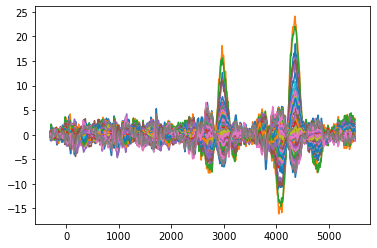

In [33]:
plt.plot(time,erp)
plt.show()

NExt we need an erp by condition, i just do 1 condition for fun here.  

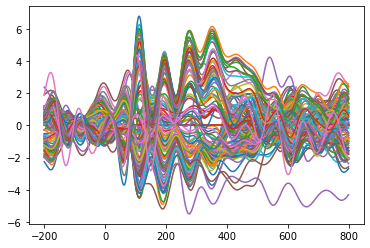

In [94]:
goodstim_1 = np.where(stim_index == 1)[0]
usetrials = np.intersect1d(goodstim_1,good_trials)
erp_1 = np.mean(eeg[usetrials,:,:],axis = 0)
erp_1 = baselinecorrect(erp_1,range(200))
plt.plot(time,erp_1)
plt.show()

Here I compute a singular value decomposition of the overall average erp, limited to a window around the P300 peak.  First I plot the temporal components, and then the spatial component(latter should be replaced by a topo map) 

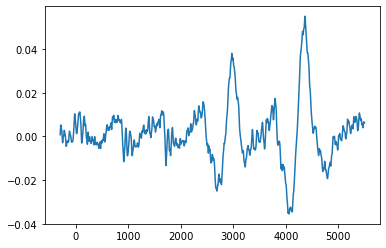

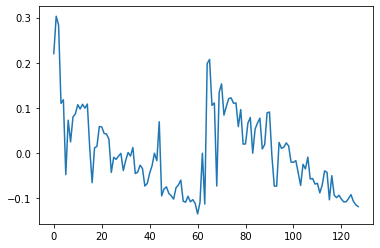

In [62]:
u,s,v = np.linalg.svd(erp[:,:])
u = -u
v = -v
plt.plot(time[:],u[:,0])
plt.figure()
plt.plot(v[0,:])

here i demonstrate that the temporal component is exactly what you would get if you take the erp and project it along the spatial component by taking a dot product with the spatial compoents  

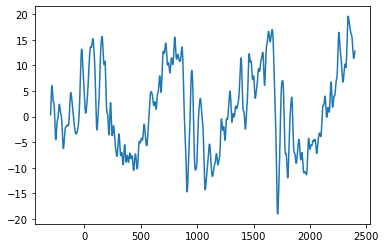

In [52]:
svderp = erp[:2700,:]@np.transpose(v[0,:])
plt.plot(time[:2700],svderp)
plt.show()

Here I show you could in principle use it at all time components, but thats not a good idea really.  you should optimize each erp window.  

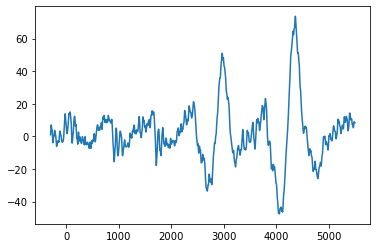

In [63]:
x1 = erp@np.transpose(v[0,:])
plt.plot(time,x1)

here i take the erp from one condition, and  project it use the spatial component of all conditions. 

Here i loop over all features, and make a plot of the P300 effect.  

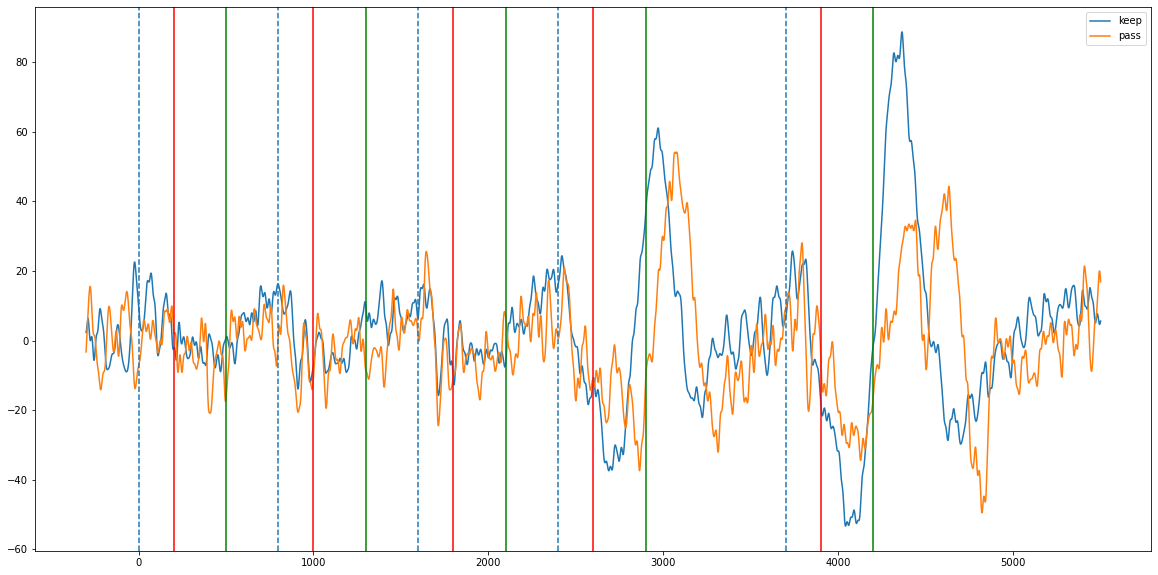

In [69]:
plt.figure(figsize=(20,10))
for i in [1,0]:
    f =  eeg[good_trials]
    inds = np.where(data['pk_choice'][good_trials] == i)
    plt.plot(time[:],np.mean(f[inds],axis=0)[:]@np.transpose(v[0,:]))
plt.legend(labels=['keep','pass'])
for i in [0,800,1600,2400,3700]:
    plt.axvline(i,linestyle='--')
for i in [200,1000,1800,2600,3900]:
    plt.axvline(i,color='r')
for i in [500,1300,2100,2900,4200]:
    plt.axvline(i,color='g')


In [56]:
svd_erp = dict()
svd_erp['channel_weights'] = v
svd_erp['temporal_components'] = u
svd_erp['singular values'] = s 
#svd_erp['erp'] = x
svd_erp['erp_by_condition'] = erp_c
svd_erp['condition_labels'] = feature_list
svd_erp['stim_index'] = stim_index
svd_erp['stim_type'] = np.array(stimtype)
svd_erp['stim_val'] = np.array(stimval)
svd_erp['good_trials'] = good_trials
svd_erp['eeg'] = eeg
outpath = f'../data/Subject{sub}/{sub}SVD_SS{ses}.hdf'
if take_ends:
    outpath = f'data/Subject{sub}/{sub}SVD_SS{ses}_end50.hdf'
savemat(outpath,svd_erp,store_python_metadata=True)

In [56]:
f.shape

(110, 5800, 128)